**Chapter 2 – End to end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3:

In [1]:
from __future__ import division, print_function, unicode_literals

import os

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Get the data

In [2]:
DATASETS_URL = "https://github.com/ageron/ml-notebooks/raw/master/datasets"

In [3]:
import os
import tarfile
import urllib.request

HOUSING_PATH = "datasets/housing"
HOUSING_URL = DATASETS_URL + "/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

Saving figure attribute_histogram_plots.png


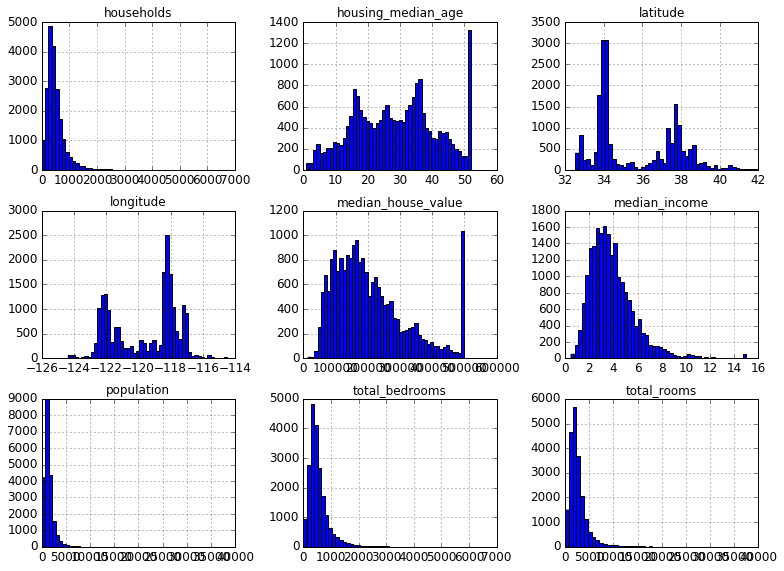

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(11,8))
save_fig("attribute_histogram_plots")
plt.show()

In [11]:
import numpy as np
import numpy.random as rnd
rnd.seed(42) # to make this notebook's output identical at every run

def split_train_test(data, test_ratio):
    shuffled_indices = rnd.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), len(test_set))

16512 4128


In [13]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(identifier).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
5,5,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY
11,11,-122.26,37.85,52,3503,752,1504,734,3.2705,241800,NEAR BAY
20,20,-122.27,37.85,40,751,184,409,166,1.3578,147500,NEAR BAY
23,23,-122.27,37.84,52,1688,337,853,325,2.1806,99700,NEAR BAY


In [15]:
from sklearn.cross_validation import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25,1505,NaN,1392,359,1.6812,47700,INLAND
3024,-119.46,35.14,30,2943,NaN,1565,584,2.5313,45800,INLAND
15663,-122.44,37.80,52,3830,NaN,1310,963,3.4801,500001,NEAR BAY
20484,-118.72,34.28,17,3051,NaN,1705,495,5.7376,218600,<1H OCEAN
9814,-121.93,36.62,34,2351,NaN,1063,428,3.7250,278000,NEAR OCEAN


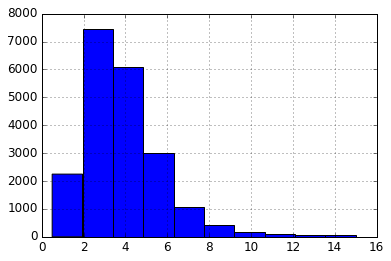

In [16]:
housing["median_income"].hist()

In [17]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [18]:
from sklearn.cross_validation import StratifiedShuffleSplit

split = StratifiedShuffleSplit(housing["income_cat"], test_size=0.2, random_state=42)
train_index, test_index = next(iter(split))
strat_train_set = housing.loc[train_index]
strat_test_set = housing.loc[test_index]

In [19]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [20]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1,0.039826,0.040213,0.039738,0.973236,-0.219137
2,0.318847,0.324370,0.318876,1.732260,0.009032
3,0.350581,0.358527,0.350618,2.266446,0.010408
4,0.176308,0.167393,0.176399,-5.056334,0.051717
5,0.114438,0.109496,0.114369,-4.318374,-0.060464


In [21]:
for set in (strat_train_set, strat_test_set):
    set.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [22]:
housing = strat_train_set.copy()

Saving figure bad_visualization.png


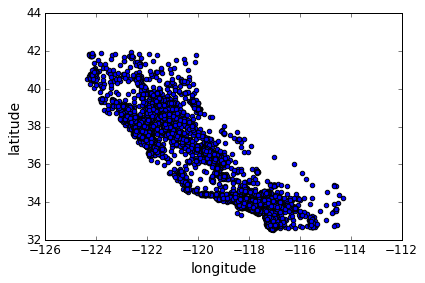

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization")

Saving figure better_visualization.png


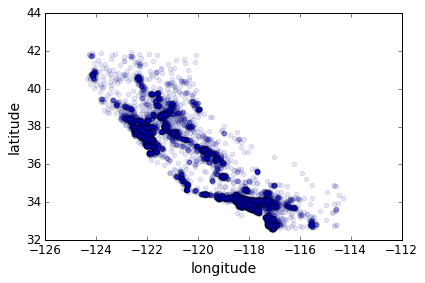

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization")

Saving figure housing_prices_scatterplot.png


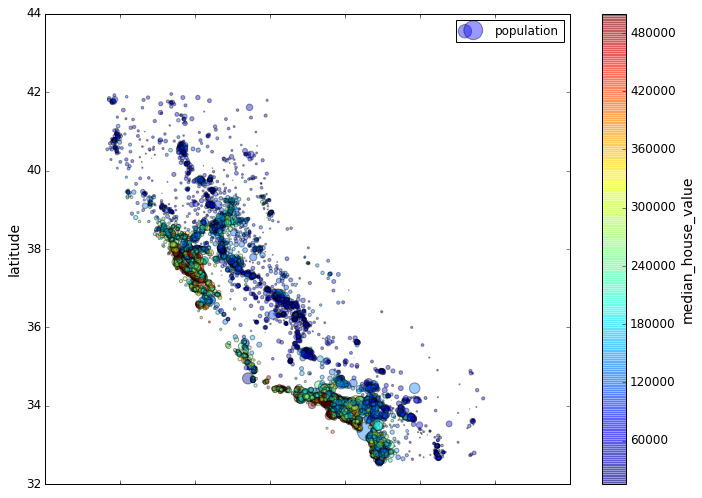

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude",
    s=housing['population']/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
save_fig("housing_prices_scatterplot")
plt.show()

Saving figure california_housing_prices.png


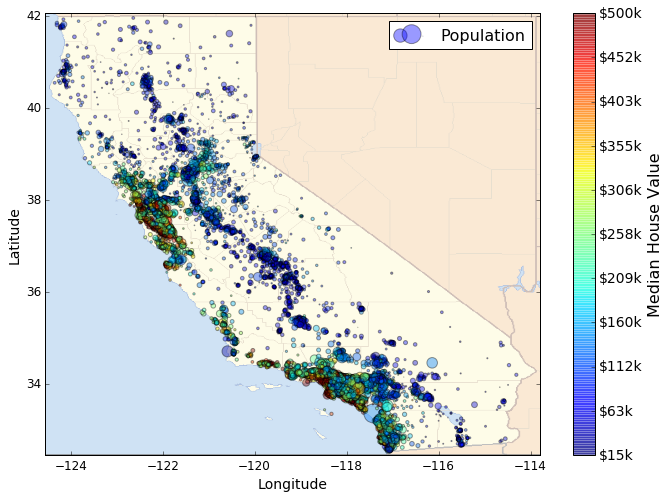

In [26]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices")
plt.show()

In [27]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687170
total_rooms           0.135231
housing_median_age    0.114220
households            0.064702
total_bedrooms        0.047865
population           -0.026699
longitude            -0.047279
latitude             -0.142826
Name: median_house_value, dtype: float64

Saving figure income_vs_house_value_scatterplot.png


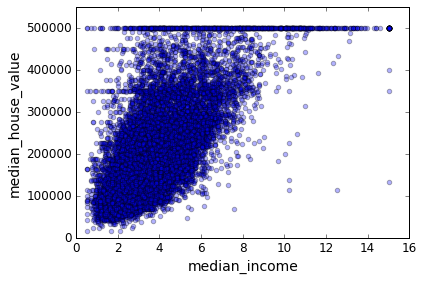

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.3)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")
plt.show()

Saving figure scatter_matrix_plot.png


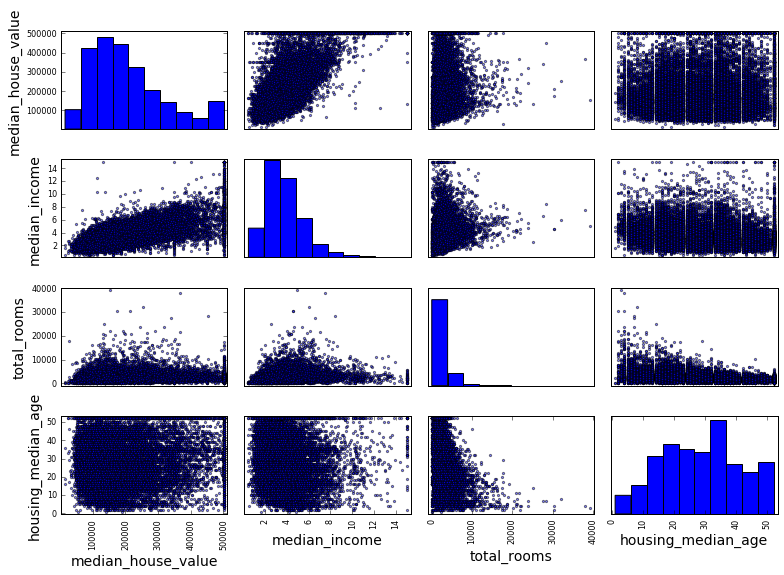

In [29]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(11, 8))
save_fig("scatter_matrix_plot")
plt.show()

In [30]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["population"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687170
rooms_per_household         0.199343
total_rooms                 0.135231
housing_median_age          0.114220
households                  0.064702
total_bedrooms              0.047865
population_per_household   -0.021984
population                 -0.026699
longitude                  -0.047279
latitude                   -0.142826
bedrooms_per_room          -0.260070
Name: median_house_value, dtype: float64

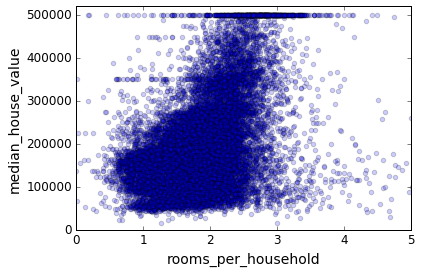

In [32]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [33]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16513.000000,16513.000000,16513.000000,16513.000000,16355.000000,16513.000000,16513.000000,16513.000000,16513.000000,16513.000000,16355.000000,16513.000000
mean,-119.575972,35.639693,28.652335,2622.347605,534.885112,1419.525465,496.975050,3.875651,207001.216193,1.982915,0.212882,3.096401
std,2.002048,2.138279,12.576306,2138.559393,412.716467,1115.715084,375.737945,1.905088,115697.548739,1.214605,0.057384,11.584473
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.002547,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1442.000000,295.000000,784.000000,278.000000,2.566800,119800.000000,1.521287,0.175304,2.431373
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541400,179500.000000,1.937931,0.203035,2.817647
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1718.000000,602.000000,4.745000,263900.000000,2.297196,0.239833,3.281250
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,55.222222,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [34]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
housing_copy = housing.copy().iloc[21:24]
housing_copy

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13546,-117.30,34.12,34,1127,275,971,249,2.0583,INLAND
6421,-117.99,34.14,30,2346,NaN,1988,474,2.5625,INLAND
2467,-119.83,36.54,31,1732,332,979,294,2.5208,INLAND


In [36]:
housing_copy.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13546,-117.30,34.12,34,1127,275,971,249,2.0583,INLAND
2467,-119.83,36.54,31,1732,332,979,294,2.5208,INLAND


In [37]:
housing_copy = housing.copy().iloc[21:24]
housing_copy.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
13546,-117.30,34.12,34,1127,971,249,2.0583,INLAND
6421,-117.99,34.14,30,2346,1988,474,2.5625,INLAND
2467,-119.83,36.54,31,1732,979,294,2.5208,INLAND


In [38]:
housing_copy = housing.copy().iloc[21:24]
median = housing_copy["total_bedrooms"].median()
housing_copy["total_bedrooms"].fillna(median, inplace=True) # option 3
housing_copy

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13546,-117.30,34.12,34,1127,275.0,971,249,2.0583,INLAND
6421,-117.99,34.14,30,2346,303.5,1988,474,2.5625,INLAND
2467,-119.83,36.54,31,1732,332.0,979,294,2.5208,INLAND


In [39]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.iloc[21:24]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
21,-117.30,34.12,34,1127,275,971,249,2.0583
22,-117.99,34.14,30,2346,433,1988,474,2.5625
23,-119.83,36.54,31,1732,332,979,294,2.5208


In [40]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.    ,   433.    ,
        1164.    ,   408.    ,     3.5414])

In [41]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.    ,   433.    ,
        1164.    ,   408.    ,     3.5414])

In [42]:
imputer.strategy

'median'

In [43]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-118.11,34.20,36,4915,725,1897,700,6.8270
1,-121.56,39.13,17,2277,608,1607,562,1.5085
2,-122.45,37.63,28,4946,848,2683,824,5.7480
3,-119.51,34.40,24,3422,596,1763,601,5.2039
4,-117.91,33.89,30,1631,212,523,216,7.8750


In [44]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 1, 4, ..., 1, 0, 3])

In [45]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [46]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16513x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16513 stored elements in Compressed Sparse Row format>

In [47]:
housing_cat_1hot.toarray()

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [48]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit_transform(housing_cat)

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-118.11,34.2,36,4915,725,1897,700,6.827,INLAND,7.02143,2.71
1,-121.56,39.13,17,2277,608,1607,562,1.5085,INLAND,4.0516,2.85943
2,-122.45,37.63,28,4946,848,2683,824,5.748,NEAR OCEAN,6.00243,3.25607
3,-119.51,34.4,24,3422,596,1763,601,5.2039,NEAR OCEAN,5.69384,2.93344
4,-117.91,33.89,30,1631,212,523,216,7.875,<1H OCEAN,7.55093,2.4213


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_pipeline.fit_transform(housing_num)

array([[ 0.73225807, -0.67331551,  0.58426443, ...,  0.60532243,
        -0.0333561 , -1.01304128],
       [-0.99102923,  1.63234656, -0.92655887, ..., -0.53182056,
        -0.02045649,  0.8158155 ],
       [-1.43558741,  0.93082666, -0.05187169, ...,  0.21514811,
         0.01378325, -0.64662762],
       ..., 
       [ 1.58640917, -0.7247603 , -1.56269499, ...,  0.34685686,
        -0.03055194, -0.52180218],
       [ 0.78220843, -0.85103388,  0.18667935, ...,  0.02492051,
         0.06151417, -0.30344645],
       [-1.43558741,  0.99630185,  1.85653668, ..., -0.22860151,
        -0.09586273,  0.10174193]])

In [51]:
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


In [52]:
housing_prepared = preparation_pipeline.fit_transform(housing)
housing_prepared

array([[ 0.73225807, -0.67331551,  0.58426443, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99102923,  1.63234656, -0.92655887, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43558741,  0.93082666, -0.05187169, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58640917, -0.7247603 , -1.56269499, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78220843, -0.85103388,  0.18667935, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43558741,  0.99630185,  1.85653668, ...,  0.        ,
         1.        ,  0.        ]])

In [53]:
housing_prepared.shape

(16513, 16)

# Prepare the data for Machine Learning algorithms

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = preparation_pipeline.transform(some_data)

print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 303104.   44800.  308928.  294208.  368704.]
Labels:		 [359400.0, 69700.0, 302100.0, 301300.0, 351900.0]


In [56]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.413493824875

In [57]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49425.757706049779

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fine-tune your model

In [59]:
from sklearn.cross_validation import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                              scoring="mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [60]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 75419.68679155  65277.50114406  69689.29907532  69413.06961047
  69870.55303565  73915.49453568  71690.06921059  71387.02253457
  77167.17307278  69065.01659   ]
Mean: 71289.4885601
Standard deviation: 3284.18632997


In [61]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 70423.5893262   65804.84913139  66620.84314068  72510.11362141
  66414.74423281  71958.89083606  67624.90198297  67825.36117664
  72512.36533141  68028.11688067]
Mean: 68972.377566
Standard deviation: 2493.98819069


In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22305.255320563127

In [63]:
from sklearn.cross_validation import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 54167.39966862  51400.65453167  52416.71234587  52329.22502749
  52605.97943202  55064.93909319  51972.09861301  50902.92848045
  54871.97635267  53620.63876711]
Mean: 52935.2552312
Standard deviation: 1357.64415235


In [64]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     68972.377566
std       2628.894380
min      65804.849131
25%      66871.857851
50%      67926.739029
75%      71575.065459
max      72512.365331
dtype: float64

In [65]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111090.2916473126

In [66]:
from sklearn.grid_search import GridSearchCV

param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'bootstrap': [False], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [67]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [68]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [69]:
for params, mean_score, scores in grid_search.grid_scores_:
    print(np.sqrt(-mean_score), np.sqrt(-scores).std(), params)

65432.9683762 1062.79550591 {'n_estimators': 3, 'max_features': 2}
55665.5605603 1427.46317644 {'n_estimators': 10, 'max_features': 2}
53033.7865875 780.72721466 {'n_estimators': 30, 'max_features': 2}
60781.345982 1399.78446559 {'n_estimators': 3, 'max_features': 4}
52658.6454557 1434.29835249 {'n_estimators': 10, 'max_features': 4}
50483.3083922 834.746790462 {'n_estimators': 30, 'max_features': 4}
59411.7682116 1335.73783795 {'n_estimators': 3, 'max_features': 6}
52418.5680495 950.028738561 {'n_estimators': 10, 'max_features': 6}
49996.3920474 809.840411239 {'n_estimators': 30, 'max_features': 6}
58637.5258588 1277.20658362 {'n_estimators': 3, 'max_features': 8}
52265.4998647 991.797551637 {'n_estimators': 10, 'max_features': 8}
50113.1069206 863.141492404 {'n_estimators': 30, 'max_features': 8}
61837.381794 1148.05219073 {'n_estimators': 3, 'bootstrap': False, 'max_features': 2}
54472.3273712 833.190757464 {'n_estimators': 10, 'bootstrap': False, 'max_features': 2}
60150.4767374 91

In [70]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='mean_squared_error')
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10d3a6278>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10d3a6400>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='mean_squared_error', verbose=0)

In [71]:
for params, mean_score, scores in rnd_search.grid_scores_:
    print(np.sqrt(-mean_score), np.sqrt(-scores).std(), params)

50324.5483907 792.353119486 {'n_estimators': 121, 'max_features': 3}
50393.4707889 859.251628456 {'n_estimators': 187, 'max_features': 3}
49306.9020626 1034.34820504 {'n_estimators': 88, 'max_features': 6}
49247.3383284 888.739748509 {'n_estimators': 137, 'max_features': 5}
49124.8374347 1016.3805842 {'n_estimators': 197, 'max_features': 7}
49956.3929273 1009.32227897 {'n_estimators': 39, 'max_features': 6}
52153.7095431 1002.38400273 {'n_estimators': 50, 'max_features': 2}
54382.0228665 960.495372118 {'n_estimators': 184, 'max_features': 1}
52037.3839985 962.681421298 {'n_estimators': 71, 'max_features': 2}
49265.776046 1064.73815338 {'n_estimators': 140, 'max_features': 6}


In [72]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.14156423e-02,   6.76139189e-02,   4.44260894e-02,
         1.66308583e-02,   1.66076861e-02,   1.82402545e-02,
         1.63458761e-02,   3.26497987e-01,   6.04365775e-02,
         1.13055290e-01,   7.79324766e-02,   1.12166442e-02,
         1.53344918e-01,   8.41308969e-05,   2.68483884e-03,
         3.46681181e-03])

In [73]:
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32649798665134971, 'median_income'),
 (0.15334491760305854, 'INLAND'),
 (0.11305529021187399, 'population_per_household'),
 (0.07793247662544775, 'bedrooms_per_room'),
 (0.071415642259275158, 'longitude'),
 (0.067613918945568688, 'latitude'),
 (0.060436577499703222, 'rooms_per_household'),
 (0.04442608939578685, 'housing_median_age'),
 (0.018240254462909437, 'population'),
 (0.01663085833886218, 'total_rooms'),
 (0.016607686091288865, 'total_bedrooms'),
 (0.016345876147580776, 'households'),
 (0.011216644219017424, '<1H OCEAN'),
 (0.0034668118081117387, 'NEAR OCEAN'),
 (0.0026848388432755429, 'NEAR BAY'),
 (8.4130896890070617e-05, 'ISLAND')]

In [74]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_transformed = preparation_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_transformed)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48209.636848454633

# Extra material

## Label Binarizer hack
`LabelBinarizer`'s `fit_transform()` method only accepts one parameter `y` (because it was meant for labels, not predictors), so it does not work in a pipeline where the final estimator is a supervised estimator because in this case its `fit()` method takes two parameters `X` and `y`.

This hack creates a supervision-friendly `LabelBinarizer`.

In [75]:
class SupervisionFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(SupervisionFriendlyLabelBinarizer, self).fit_transform(X)

# Replace the Labelbinarizer with a SupervisionFriendlyLabelBinarizer
cat_pipeline.steps[1] = ("label_binarizer", SupervisionFriendlyLabelBinarizer())

# Now you can create a full pipeline with a supervised predictor at the end.
full_pipeline = Pipeline([
        ("preparation", preparation_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline.fit(housing, housing_labels)
full_pipeline.predict(some_data)

array([ 303104.,   44800.,  308928.,  294208.,  368704.])

## Model persistence using joblib

In [76]:
from sklearn.externals import joblib

In [77]:
joblib.dump(final_model, "my_random_forest_regressor.pkl")

['my_random_forest_regressor.pkl',
 'my_random_forest_regressor.pkl_01.npy',
 'my_random_forest_regressor.pkl_02.npy',
 'my_random_forest_regressor.pkl_03.npy',
 'my_random_forest_regressor.pkl_04.npy',
 'my_random_forest_regressor.pkl_05.npy',
 'my_random_forest_regressor.pkl_06.npy',
 'my_random_forest_regressor.pkl_07.npy',
 'my_random_forest_regressor.pkl_08.npy',
 'my_random_forest_regressor.pkl_09.npy',
 'my_random_forest_regressor.pkl_10.npy',
 'my_random_forest_regressor.pkl_11.npy',
 'my_random_forest_regressor.pkl_12.npy',
 'my_random_forest_regressor.pkl_13.npy',
 'my_random_forest_regressor.pkl_14.npy',
 'my_random_forest_regressor.pkl_15.npy',
 'my_random_forest_regressor.pkl_16.npy',
 'my_random_forest_regressor.pkl_17.npy',
 'my_random_forest_regressor.pkl_18.npy',
 'my_random_forest_regressor.pkl_19.npy',
 'my_random_forest_regressor.pkl_20.npy',
 'my_random_forest_regressor.pkl_21.npy',
 'my_random_forest_regressor.pkl_22.npy',
 'my_random_forest_regressor.pkl_23.npy',

In [78]:
final_model_loaded = joblib.load("my_random_forest_regressor.pkl")
final_model_loaded

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

## Example SciPy distributions for `RandomizedSearchCV`

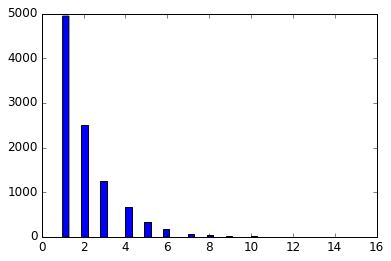

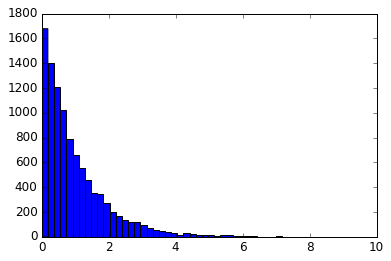

In [79]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000)
expon_distrib=expon(scale=1).rvs(10000)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()